# Abstract

This notebook provides in-depth look at DCGANs, the motivation behind them, and a highly detailed overview of the optimization techniques and tricks necessary to stabilize training between a Generator/Discriminator pair. This is my implementation of [Radford et al, 2015](https://arxiv.org/abs/1511.06434) with the addition of techniques presented in [Improved GAN, Salimans et al 2016](https://arxiv.org/abs/1606.03498), [Spectral Normalization, Miyato et al 2018](https://arxiv.org/abs/1802.05957), and others. I stray from the common path and try to generate sort-of-HD CelebA images in their original, rectangular, 5:4 aspect ratio at 157x128. 

The GAN was first introduced in 2014 by [Goodfellow et al](https://arxiv.org/abs/1406.2661): A pair of two feed-forward networks - a Generator and Discriminator -  play a min-max game with each other in an attempt to learn the distribution of image training data and reconstruct it from low-dimensional Gaussian latent vectors.

The GAN was quickly followed by the DCGAN by [Radford et al](https://arxiv.org/pdf/1511.06434v2), a GAN implemented with two separate CNN models. The DCGAN has since taken the mainstage for image generation tasks and has seen many improved iterations dealing with the stability of the min-max game played by the two opposing networks.

The difficulty of training the GAN speaks for itself - once you give it a shot. Achieving stability in training and ensuring convergence to a nash equillibrium is not nearly as easy as it is made out to be by recent DCGAN papers implementing weight and image regularization techniques such as SELU and Spectral Norm. The plain DCGAN, even with contemporary regularization techniques, doesn't quite cut it in the state-of-the-art - but comes surprisingly close for its simplicity. Progressively Growing GANs and the MSG-GAN are some better, more recent candidates which build on the DCGAN to produce truly impressive results at higher resolutions.

<!--TABLE OF CONTENTS-->
# Table of Contents:
- [Intro to GANs](#Intro-to-GANs)
- [Dataset Setup & Inspection](#Dataset-Setup-&-Inspection)
    - [Preprocess Images: Resize, Normalize](#Preprocess-Images:-Resize,-Normalize)
- [Training a GAN](#Training-a-GAN)
- [The DCGAN Architecture](#The-DCGAN-Architecture)
- [Stabilizing a DCGAN: One Weird Trick(s)](#Stabilizing-a-DCGAN:-One-Weird-Trick)
    - [Activation functions](#Activation-functions)
    - [SELU and Self-Normalizing Neural Networks](#SELU-and-Self-Normalizing-Neural-Networks)
    - [Spectral Normalization](#Spectral-Normalization)
    - [Minibatch Standard Deviation](#Minibatch-Standard-Deviation)
    - [Pixelwise Normalization](#Pixelwise-Normalization)
    - [WGAN / Wasserstein Loss](#WGAN-/-Wasserstein-Loss)
    - [Gaussian Instance Noise](#Gaussian-Instance-Noise)
    - [Batch Size](#Batch-Size)
    - [Latent Vector Dimension](#Latent-Vector-Dimension)
- [Building a DCGAN](#Building-a-DCGAN)
    - [Building the Generator Network](#Build-Generator-Network)
    - [Building the Discriminator Network](#Build-Discriminator-Network)
    - [Verifying Model Architecture](#Verify-Model-Architecture)
    - [Choice of Optimizer and Loss Function](#Choice-of-Optimizer-and-Loss-Function)
- [Training a DCGAN](#Training-a-DCGAN)
    - [Making Training Utilities](#Make-Training-Utilities)
    - [Building Training Loop](#Build-Training-Loop)
    - [Tracking Progress with TensorBoard](#Track-Progress-with-TensorBoard)
    - [Configuring Training Params & Training Model](#Configure-Training-Params-&-Train-Model)
    - [Loading Pre-Trained Checkpoints to Resume Training](#Load-Pre-Trained-Checkpoints-to-Resume-Training)
- [Testing Model](#Test-Model:-Generate-Images)
  - [Image Generating Utilities](#Image-Generating-Utilities)
  - [Generated Images and Checkpoint Progression](#Generated-Images-and-Checkpoint-Progression)
- [Lessons Learned: How to Stabilize and Optimize a GAN](#Lessons-Learned:-How-to-Stabilize-and-Optimize-a-GAN)
- [References](#References) 

<br>

- [Appendix A](#Appendix-A)
  - [Animating GAN Training Progress](#Animating-GAN-Training-Progress)
  - [Spherical Interpolation](#Spherical-Interpolation)
  - [CelebA Attributes](#CelebA-Attributes)
  - [Wasserstein Loss: The WGAN](#Wasserstein-Loss:-The-WGAN)

# Intro to GANs

In this notebook I'm going to give a brief intro to Generative Adversial Networks (GANs) and an in-depth analysis of Deep Convolutional GANs (DCGANs) and their tuning.

[GANs were first introduced by Goodfellow et al in 2014.](https://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf)

We can imagine any training data to lie in an n-dimensional space - for example, 28x28 images from MNIST
can be sampled from a 28x28 = 784-dimensional space; each of 784 pixels in each image has a probability
associated with all its possible values, i.e. pixel values in range [0,255]). **Hence, MNIST images can be represented by a probability distribution - one image is a point in a 784-dimensional space** 

<img src="img/bivariate gaussian distro.jpg">

<sub><center> A bivariate gaussian distribution of a 2 dimensional space. The height of the plot is the probability of a certain data point appearing. In reality, this plot would have many peaks and can only be visualized on a 784-dimensional MNIST image by first reducing its dimensionality (e.g. with PCA). Image by [Raghavendra Selvan](https://www.researchgate.net/project/Bayesian-Tracking-of-Multiple-Point-Targets)</center></sub>

The idea is simple: Two networks act as adversaries - the generator (G) has the objective to fool the discriminator (D), while D has the objective to not be fooled.
G samples data from a random distribution. D is fed either samples from G or samples from real training data and attempts to classify 
G's output as having come from the real training data distribution or not. 


**G is penalized by outputs which D accurately classifies as fakes; it thus learns to generate data as close
as possible to the real training data distribution.** 

<img src="img/generator.png">

<sub><center>Generator training process; loss is based on discriminator's prediction on generated images. Figure adapted from [Google GAN overview](https://developers.google.com/machine-learning/gan/gan_structure)</center></sub>

**D is penalized by incorrectly classifying fake inputs as real and vice versa; it thus learns to identify fake 
data; D's role is to provide feedback to and facilitate G's learning.**

<img src="img/discriminator.png">

<sub><center> Discriminator training process; loss is based on discriminator's predictions on both fake and real images. Figure adapted from [Google GAN overview](https://developers.google.com/machine-learning/gan/gan_structure)</center></sub> 



For game theory enthusiasts, the generator-discriminator network pair are playing a [minimax game](https://en.wikipedia.org/wiki/Minimax) against each other; their objective function is the predictability of G's output. G tries to minimize predictability while D tries to maximize it.

**When G reaches its optimal strategy, loss converges at a Nash equillibrium for both networks at a saddle point in the objective function representing their game.**

According to Goodfellow et al, the networks' strategy converges when G recovers the training data as
truthfully as possible and D can't distinguish between fake and real data, being 50% sure that anything G makes is real - and at this point neither G nor D can do their task any better.

**Once G can generate such data, it will theoretically be able to generate images closely resembling real training data by sampling from a low-dimensional space.**

Both networks can be trained by backpropogation; common implementations of generator-discriminator network pairs are 
multilayer perceptrons and CNNs. In this notebook, we'll implement the CNN-based GAN: the DCGAN



In [1]:
import os
import re
import time
import enum

import cv2 as cv
import numpy as np
from scipy.special import expit
import matplotlib.pyplot as plt

import torch
import torchvision.utils
from torch import nn
from torch.optim import Adam, AdamW, SGD
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

In [2]:
# need to import files from google drive into colab 
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


We'll try applying the GAN paradigm on the MNIST dataset, our objective being to generate real handwritten digits.


Just kidding. [MNIST is no good for computer vision](https://twitter.com/fchollet/status/852594987527045120): Ian Goodfellow, the original author of GANs, and Francois Chollet, Keras author, give a few details in the above link to their twitter conversation: the gist is that **when you use MNIST, often good CV optimizations don't work, and bad ones do. So MNIST is a poor representation of CV tasks.**

Instead, we're going to use CelebA: Celebrity Face Attributes by [Liu et al, 2015](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html)

In [ ]:
# copy CelebA dataset from (my) gdrive and unzip
!cp '/content/gdrive/My Drive/DL/DCGAN/datasets1.zip' .
!unzip -q datasets1.zip 
print('CelebA dataset loaded from gdrive')

# Dataset Setup & Inspection

We can download the CelebA dataset using PyTorch directly, as below - but it usually errors due to a limitation with the gdrive where it is hosted. Instead, download it from the [CelebA homepage by Liu et al](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html). More details on obtaining CelebA provided in code comments.

We'll use torch.datasets.CelebA to make use of its built-in train set split, in place of torch.datasets.ImageFolder, which we would need for a custom dataset. We don't really need train and test sets here - but the **CelebA dataset does specify train/test/validation partition in a text file, so we'll use the training partition to make our results comparable to other DCGAN implementations trained on CelebA.**

In [131]:
# CelebA (Celebrity Face Attributes), included with PyTorch
# if you try to download fom PyTorch you may encounter an error 
# in that case download from official (Liu et al) baidu drive: https://pan.baidu.com/s/1CRxxhoQ97A5qbsKO7iaAJg
# password "rp0s" for baidu drive
# torch tries to download from (Liu et al) gdrive which has a limit on how many downloads it can provide 
# but try it out; you might get lucky. Otherwise, this function just loads from 'root' on disk
class CelebA():
    def __init__(self, split, transform=transforms.ToTensor()):
        self.data = datasets.CelebA(root='./datasets/CelebA', split=split, download=True, transform=transform)
        
    def __getitem__(self, index):
        x = self.data[index]
        return x

    def __len__(self):
        return len(self.data)

In [133]:
# instantiate the dataset as an object 
dataset = CelebA(split='train', transform=transforms.ToTensor())

# choose a batch size - 128 used in original DCGAN by Radford et al, but lower is better. More on this later.
# I ultimately used a batch size of 32 which has been used by more recent DCGAN papers such as HDCGAN by Curto et al. 
# Create a PyTorch DataLoader object which returns CelebA images in shuffled batches of 32, 
# discarding the last batch of <32 images with drop_last=True
dataloader = DataLoader(
    dataset,
    batch_size=32,
    num_workers=1,
    shuffle=True,
    drop_last=True
)

# check dataset size
print(f'CelebA: {dataset.__len__()} celebrity face training images.')

# generate a batch of images from our dataloader
batch = next(iter(dataloader))  

# images in (C,H,W) format
print(f'Images are size {batch[0].size()[1:]} (C,H,W)')
# check pixel values 
print(f'Pixel values are in range [{torch.min((batch[0][0]))}, {torch.max((batch[0][0]))}]')

# Check labels
print(f'\nLabels are size {batch[1].size()[1:]}')
# should have 40 boolean labels
print(f'CelebA attribute labels: {batch[1][0]}')

Files already downloaded and verified
CelebA: 162770 celebrity face training images.
Images are size torch.Size([3, 218, 178]) (C,H,W)
Pixel values are in range [0.0, 1.0]

Labels are size torch.Size([40])
CelebA attribute labels: tensor([0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1])


We get ~160k images in the CelebA training set and our dataloader returns two tensors per batch - one with 32 RGB images, one with 32 labels. According to [Liu et al, 2015](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html), images each have 40 boolean labels representing various visual attributes such as:
 - wearing a hat
 - pointy nose
 - wavy hair
 - sunglasses
 - and so forth. 

# Preprocess Images: Resize, Normalize

The dataset is loaded by TorchVision into a PIL Image with pixel values in range [0,255], while torch.transforms.ToTensor converts the PIL Image to a Float Tensor of shape (C,H,W) in range [0,1]. **We're going to want to normalize these images to [-1,1] before training the discriminator on them because the DCGAN generator uses tanh activation, producing images also in range [-1,1]. From [Radford et al, 2015](https://arxiv.org/pdf/1511.06434v2):** _"We observed that using a bounded [tanh] activation [in the generator's final layer] allowed the model to learn more quickly to saturate and cover the color space of the training distribution."_

We normalize pixels with _pixels = (pixels - mean) / stdev_. **I've seen some DCGAN implementations use a mean of 0.5 and stdev of 0.5 for all pixel values and image batch dimensions, which is incorrect**. The PyTorch image normalization documentation uses values of mean = (0.485, 0.456, 0.406), stdev = (0.229, 0.224, 0.225), which are the values from the [ImageNet dataset](http://www.image-net.org/) - which is the correct way to do it. We'll calculate the mean and stdev of each pixel dimension in (C,H,W) and use those to properly normalize the images to [-1,1].

We use the aligned & cropped CelebA dataset, provided at 218x178. **We'll keep the 5:4 rectangular aspect ratio and resize the images to 157x128 to slightly lower the complexity of the required network, else we would require extra layers to upsample/downsample larger images.** 

In [135]:
# Get real mean and stdev of each pixel dimension in (C,H,W) in the batch of 10k images
# For reference, ImageNet uses mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
def get_stats(dataloader):
    tot_pixels = 0
    num_samples = 0
    mean = torch.empty(3)
    stdev = torch.empty(3)

    for data in dataloader:
        data = data[0]
        b, c, h, w = data.shape
        num_pixels = b * h * w
        sum_ = torch.sum(data, dim=[0, 2, 3])
        sum_of_square = torch.sum(data ** 2, dim=[0, 2, 3])
        mean = (tot_pixels * mean + sum_) / (tot_pixels + num_pixels)
        stdev = (tot_pixels * stdev + sum_of_square) / (tot_pixels + num_pixels)
        num_samples += 1
        tot_pixels += num_pixels
        print('\r'+f'{(num_samples / len(dataloader)*100):.3f}% processed',end='')

    return mean, torch.sqrt(stdev - mean ** 2)

mean, stdev = get_stats(dataloader)

print(f'\nPixel Mean: {mean}, Pixel Stdev: {stdev}')

100.000% processed
Pixel Mean: tensor([0.5063, 0.4258, 0.3832]), Pixel Stdev: tensor([0.3107,0.2904,0.2897]


Close, but not exactly the same as ImageNet. **Certainly not (0.5,0.5,0.5) for both mean and stdev.** 

Now reload the dataset resized, and normalized to [-1,1] according to the values from the previous step. We'll create a composite transform using TorchVision for this:

In [491]:
# images are often represented by pixel brightness values in a range [0,255] 
# Normalizing pixel values to the [-1,1] range helps train GANs: see https://github.com/soumith/ganhacks
# make a PyTorch function which moves PIL images to a tensor and normalizes them to [-1,1]:
resize_normalize = transforms.Compose([
        transforms.Resize(size=(157,128)),
        transforms.ToTensor(),
        #For reference, ImageNet uses mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
        transforms.Normalize(mean=[0.5063,0.4258, 0.3831], std=[0.3107,0.2904,0.2897], inplace=True)  
    ])

# instantiate the resized and normalized dataset  
dataset = CelebA(split='train', transform=resize_normalize)

# create a new dataloader with the processed dataset images
dataloader = DataLoader(
    dataset,
    batch_size=32,
    num_workers=1,
    shuffle=True,
    drop_last=True
)

# get a batch from the dataloader
batch = next(iter(dataloader))

# check that we've normalized to [-1,1] correctly by inspecting pixel dimensions
# batch[0] --> (N,C,H,W); batch[0][0] --> (C,H,W) containing image pixel values 
# we want to make sure all pixels in all 3 RGB channels are between [-1,1], i.e. in (C,H,W)
print(f'{batch[0][0][0].numel()} pixels in each {batch[0].size()[2]}x{batch[0].size()[3]} RGB image')
print(f'Pixel values are in range [{torch.min((batch[0][0]))}, {torch.max((batch[0][0]))}]')

Files already downloaded and verified
20096 pixels in each 157x128 RGB image
Pixel values are in range [-1.0, 1.0]


Looks good - 157x128 RGB images with pixels normalized to [-1,1].

Let's look at the images:

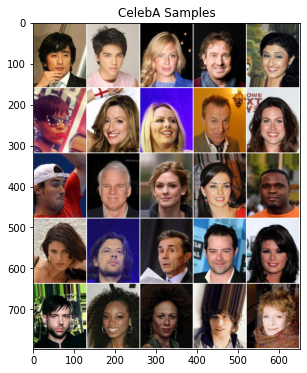

In [492]:
# get the images from the batch
img = batch[0]

# we'll visualize a 4x4 grid of images
img_grid_size = 5
img_grid = img[:img_grid_size**2] 

# make a grid of images from the tensor; normalize to [0,1] so all pixels are visible
# make_grid pads images with 2 black pixels by default; set pad_value==white (1) so we can see a grid
grid = torchvision.utils.make_grid(tensor=img_grid,nrow=img_grid_size, normalize=True,pad_value=1)

# swap H,W dimensions for matplotlib's imshow() to work properly
grid = np.moveaxis(grid.numpy(), 0, 2) 

# plot images 
plt.figure(figsize=(6, 6))
plt.title("CelebA Samples")
# imshow plots axes with # of pixels by defaul|t
plt.imshow(grid)
plt.show()

Those are faces alright, presumably of celebrities. 

And our dataset is ready to use.

# Training a GAN
Common implementations of generator-discriminator network pairs use
multilayer perceptrons and CNNs.
Both networks of a GAN can be trained by backpropogation of the error from the adversarial loss function, as introduced by [Goodfellow et al, 2014](https://arxiv.org/pdf/1406.2661.pdf):

<img src="img/adversarial loss.GIF"><sub><center>Image from Goodfellow et al, 2014.</center></sub>

- _x_ is an image in (C,H,W) format. 
- _z_ is a vector constructed by sampling from  a latent space learned by the generator
- _D(x)_ is the discriminator function which outputs the probability that _x_ comes from the distribution of the real training data. The function _D_ is simply a binary classifier - real data, or fake data.
- _G(z)_ is the generator function, transforms the latent space vector _z_ to the same space as the training data (i.e. 3x32x32 for MNIST)
- _p<sub>data</sub>_ is the probability distribution of the real training data
- _p<sub>z</sub>_ is the probability distribution of the fake training data output by _G(z)_
- _D(G(z))_ is the probability that G(z) is classfied same as real data, G(x)
- D learns to output lim_D(x)_ -> 1, and lim_D(G(z))_ -> 0
- D's objective is to maximize log(D(x)) - log probability of classifying real data as real data
- G's objective is to minimize log(1-D(G(z))) - log inverted probability of classifying fake data as real data (i.e. prob of classifying fake data as fake data

We use log probability so probabilities are additive (otherwise the product of probabilities would always approach 0). 
The GAN's loss function is then just binary cross-entropy over outputs from two batches of data; real and fake.
In Goodfellow et al, the authors say that log(1-D(G(z)) saturates when G is poorly trained and D is well trained.
According to [Arjovsky and Bottou, 2017](arxiv.org/pdf/1701.04862.pdf), if the discriminator is too good, then its loss gradients will vanish and so the generator will not learn: An optimized disciminator precludes the generator from making progress.

**As such, in practice G is trained by maximizing log(D(G(z))** which provides higher gradients, faster training, and a lesser likelihood of a vanishing gradient. In sum: Instead of training the GAN to minimize D being correct, we train the GAN to maximize that D is incorrect.

And that's it - that's the meat of the GAN, the adversarial loss function: just a doubled application of binary cross entropy.



# The DCGAN Architecture
It is identical to the original GAN architecture, but uses CNNs for both G and D (instead of dense MLPs).
 
We should first understand transpose 2D convolutional layers, used for upsampling latent Gaussian vectors into 2D generated images. 

<img src="img/conv2dtranspose.gif" width=500 height=500>
<sub><center> Conv2D Fractionally Strided, i.e. Transpose Kernels; stacked across input channels, they create 3D Conv2D Transpose Filters</center></sub>

Conv transpse is sort of like the opposite of maxpool; conv transpose layers increase dimensionality of their inputs.
However, conv transpose is unlike maxpool in that it uses kernels with weights, as in regular Conv2D layers. **In transpose convolutional layers, we achieve upsampling by taking the product of _each_ (single) value in the input volume
with each (of many) weights of the filter.** 

From [The original DCGAN by Radford et al](https://arxiv.org/abs/1511.06434), we build the discriminator CNN with:
 - Strided convolutions (CNN filters)
 - No Pooling layers 
 - Batch Norm
 - LeakyReLU activation (ReLU that doesn't saturate below 0) for all layers 

We build the generator CNN with:
 - Fractional Strided Convolutions (Conv-Transpose Filters)
 - No Pooling layer
 - BatchNorm
 - ReLU activation for all layers except
 - Tanh only on output layer

And they also suggest to avoid fully connected layers in deeper architectures. I've followed these guidelines and then made improvements on them, drawing from papers that followed the DCGAN such as [The Improved GAN, Salimans et al, 2016](https://arxiv.org/abs/1606.03498) and [Progressive Growing GANs, Karras et al, 2017](https://arxiv.org/abs/1710.10196).


The input to the generator is a latent space vector _z_ sampled from a standard normal distribution. Its output is an image in standard (C,H,W) format. The Conv2D Transpose filters transform the 1D vector into a 3D volume,
in direct and opposite analogy to the way regular Conv2D layers transform 3D inputs into 1D vectors, as will our discriminator.

<img src="img/conv2d transpose.png">

<sub><center>Generator from Radford et al. A "backwards" CNN, where a 100-dimensional Gaussian vector is projected to 3D feature map representation by reshaping. Then transpose Conv2D layers transform the input vector into intermediate feature maps and eventually, an image.</center></sub>

Notably, fully connected hidden layers are avoided. **I've used an FC linear layer to upsample the 100-dim input vector to the discriminator's input convolutional filter, while the discriminator 'flattens' its output by a final convolutional layer which produces a scalar.** 

Some DCGAN implementations use 1024 filters in the first discriminator and last generator layer - I found no improvement over 512 filters in that layer, with about half the model parameters required. [HDCGAN](https://arxiv.org/abs/1711.06491) used 64 filters in each of its layers - so **it seems that number of filters is less significant than other aspects of the network architecture, particularly normalization of output feature maps.**

Finally, the original DCGAN uses sigmoid activation on the final discriminator layer along with regular binary cross entropy (BCE) loss. **However, I use BCE with logits and no sigmoid activation on the final discriminator layer, which is more numerically stable because we use the log-sum-exp (LSE) trick by combining a sigmoid layer and log-loss in one class.**

----------

# Stabilizing a DCGAN: One Weird Trick
Now we can define the GAN with some caveats. GANs in general, and especially DCGANs are notoriously unstable due to the competitive interplay between the Discriminator/Generator pair, which encourages weights to spiral out of control for one network to beat the other - and that is the case unless both networks are very carefully tuned. Some recent advances in GAN architecture will help:

### Activation functions

I found LeakyReLU to work best, as suggested in the original DCGAN paper. I tried ReLU - which lead to less stable loss dynamics and lower gradients - and SELU (Scaled Exponential Linear Unit) - which had its advantages, see below. 

Otherwise, I'm going to implement some tricks from recent years that were developed after DCGAN came out.  These are mostly normalization techniques - this is necessary so that the discriminator loss is stable and doesn't go to 0 - training collapse - when the discriminator learns too quickly and and the generator is left with zero information gain.  

### SELU and Self-Normalizing Neural Networks 
Self-Normalizing Neural Networks (SNNs) were introduced by [Klambauer et al, 2017](https://arxiv.org/abs/1706.02515) with the SELU activation. They show that activations with close to zero mean and unit variance converge towards zero mean and unit variance as they are propogated through network layers. They show that there is an upper bound on activations that aren't close to zero mean and unit variance as well - so gradient issues become "impossible". SELU worked to normalize regular machine learning models and dense feedforward networks with many layers. 

<img src="img/SNN.GIF"><sub><center>Loss on CIFAR-10 classificaiton task using FC feedforward networks, comparing BatchNorm vs SNN at different numbers of hidden layers. Image from [Klambauer et al, 2017](https://arxiv.org/pdf/1706.02515.pdf) </center></sub>

In the [HDCGAN](https://arxiv.org/pdf/1711.06491.pdf), they found that using SELU in conjunction with [BatchNorm](https://arxiv.org/abs/1502.03167) results in model activations with mean close to 0 and variance close to 1. I took inspiration from this paper to try SELU here.

"[Using SELU+BatchNorm] ... given a sufficiently large sample size by the Central Limit Theorem, we can attain NASH equilibrium." -[Curto et al, 2020](https://arxiv.org/pdf/1711.06491.pdf)

However, they found SELU not to work as well in practice, supposedly due to numerical errors introduced by GPU calculation - so they used BatchNorm to overcome this problem. They say this paradigm greatly increased convergence speed.

**I found SELU activation + BatchNorm to work well, but not better than properly tuned LeakyReLU, and at a higher computational cost. I ultimately stuck with LeakyReLU. I attribute this result to the normalizing properties of Spectral Normalization + Batch Normalization - so SELU had little to work on. The idea is sound though - I suspect it will be much more important in larger (>512x512) DCGAN tasks.**

### Spectral Normalization
Proposed in [Miyato et al, 2018, Spectral Normalization for Generative Adversarial Networks](https://arxiv.org/abs/1802.05957). They find that Spectral Norm for model weights outperforms the use of gradient penalty for weight normalization in the WGAN-GP, and at lower computational cost. 

**Spectral Normalization constrains the [Lipschitz constant](https://en.wikipedia.org/wiki/Lipschitz_continuity) (uniform continuity) of the convolutional filters. In the discriminator, for example, discriminator(x) and discriminator(y) will be sufficiently close granted that distribution of (x) and (y) are sufficiently close, which stabilizes training.** 

<img src="img/specnorm.GIF"><sub><center> Imapct of Spectral Normalization (SN) on CIFAR-10 image generation task (Inception score ~= generated image quality) at different Adam hyperparameters (lr, b1, b2) represented by A,B,C,D,E,F. SN makes GANs highly robust to hyperparameter choice. Image from [Miyato et al, 2018](https://arxiv.org/pdf/1802.05957.pdf) </center></sub>

**With the global weight regularization of the discriminator using Spectral Normalization, we obtain more diverse generated images. I found this to be true, and to also help when added on the Generator.**

### Minibatch Standard Deviation
From [Salimans et al 2016, Improved Techniques for Training GANs](https://arxiv.org/abs/1606.03498), they introduce 
"Minibatch discrimination". The idea is to compute feature stats across entire minibatches (not just for each image) and append it to the feature map of each image within that minibatch, the aim being to have generated and real training images match more closely in their statistics. They implement it with a layer at the end of the discriminator which learns a tensor of weights to project the activation to an array of statistics which is used as a feature by the discriminator. [Karras et al, 2018 - Progressive Growing of GANs For Improved Quality, Stability, and Variation](https://arxiv.org/pdf/1710.10196.pdf) suggest a simpler approach they call "Minibatch Standard Deviation", without the weighted tensor. In their approach, **we take the standard deviations of each feature over the entire minibatch and average them, concatenating that to the minibatch as a single additional feature map. Goes on the last layer of the discriminator, before activation.** 

### Pixelwise Normalization
Pixelwise Normalization is another technique suggested by [Karras et al, 2018](https://arxiv.org/pdf/1710.10196.pdf) in their progressively growing GANs paper. While we usually use BatchNorm in the generator after each conv2d layer, the progressive GAN instead uses pixelwise normalization to transform the feature vector of each pixel in each image to unit length after the last conv2d layer. I've also seen some implementations stack BatchNorm and pixelwise normalization. Karras et al say that pixelwise normalization does not harm the generator in any way, but does prevent activation magnitudes from spiralling out of control due to the competition between discriminator and generator. **In the implementation of pixelwise norm, each pixel in the feature map is simply divided by the L2 norm over that pixel's RGB channels; goes after BatchNorm in generator layers.**


### WGAN / Wasserstein Loss
I've discussed the WGAN above - and since the idea is to minimize the distance betwene the distribution of the training data and generated data, this should work great. Unfortunately,
WGAN doesn't work as well as intended. For example, in [Mescheder et al, 2018, Which Training Methods for GANs do actually Converge?](https://arxiv.org/pdf/1801.04406.pdf), WGAN seems to fail to reach convergence and is outperformed in this regard by all other recent implementations - even the regular unregularized GAN authored by Goodfellow et al in 2014. 

WGAN loss is simple to implement:

    Discriminator (Critic) Loss = [average critic score on real images] – [average critic score on fake images]
    Generator Loss = -[average critic score on fake images]

And we would then clip the weights of the discriminator to [-C, C] (using torch.clamp on model params) at every iteration simplying using to enforce a [Lipschitz constraint](https://en.wikipedia.org/wiki/Lipschitz_continuity) on the discriminator. C=0.05 worked OK for me but not at all great.

From Mescehder et al, 2018: _"Our
findings show that neither Wasserstein GANs (WGANs) (Arjovsky et al., 2017) nor Wasserstein GANs with Gradient
Penalty (WGAN-GP) (Gulrajani et al., 2017) converge on this simple example ... On the other hand, we show that instance noise (Sønderby
et al., 2016; Arjovsky & Bottou, 2017) ... lead to local convergence_"

**WGANs aren't ideal. So I used instance noise instead as suggested by [Sonderby at al, 2016](https://arxiv.org/abs/1610.04490) and verified by [Mescheder et al, 2018](https://arxiv.org/pdf/1801.04406.pdf).** I implemented WGAN loss in the training loop to test it out - it didn't do me any favours.

### Gaussian Instance Noise 
From [Sonderby et al, 2016](https://arxiv.org/abs/1610.04490), they propose (in the appendix) using instance noise in GANs to stabilize training. It's motivated by the lack of congruence between the supports of the generated and real training data. 

**I implemented instance noise by using 10% of the input tensor's pixel values as the standard deviation of noise added to that tensor from a normal (Gaussian) distribution.** 

### Batch Size
Recent papers use smaller batch sizes, such as [HDCGAN](https://arxiv.org/pdf/1711.06491.pdf) with a batch size of 32. There are many more implementations using smaller batch sizes, and I found this to indeed work better than batch sizes of 128 or larger, especially when dealing with image resolutions larger than 64x64. **Smaller batch sizes should avoid the discriminator learning too quickly and overpowering the generator, especially early in training.**


### Latent Vector Dimension
The dimension of the latent space vector we give to the generator should determine the quality of its output. However, 100-dimensional latent vectors (_z_) are used in the original DCGAN by Radford et al and in a ton of DCGAN papers to this day. **This number can be reduced with little loss in quality, while higher latent vector dimension leads to higher computational cost with impereceptible improvements, if any.**

**We'll implement and try out Gaussian instance noise, Spectral Normalization, Pixelwise Norm, and Minibatch Standard Deviation. We'll also try SELU activation.**

# Building a DCGAN

In [136]:
# simple addition layer of gaussian instance noise 
# suggested in https://arxiv.org/abs/1906.04612
class GaussianNoise(nn.Module):
    # sigma: sigma*pixel value = stdev of added noise from normal distribution 
    def __init__(self, sigma=0.1):
        super().__init__()
        self.sigma = sigma
        self.register_buffer('noise', torch.tensor(0))

    def forward(self, x):
        if self.training and self.sigma != 0:
            # scale of noise = stdev of gaussian noise = sigma * pixel value 
            scale = self.sigma * x.detach()
            sampled_noise = self.noise.expand(*x.size()).float().normal_() * scale
            x = x + sampled_noise
        return x 

# spectralnorm constrains the Lipschitz constant (strong form of uniform continuity) of the convolutional filters 
# i.e. discriminator(x), discriminator(y) will be sufficiently close granted that distribution of (x) and (y) are sufficiently close 
# stabilizes the training of the| discriminator network. works well in practice, but slows down discriminator
# may need to adust discriminator learning rate (2-4x greater than that of generator)
class SpectralNorm(nn.Module):
    def __init__(self, module):
        super().__init__()
        self.module = nn.utils.spectral_norm(module)
    def forward(self, x):
        return self.module(x)

# From Progressively Growing GANs https://arxiv.org/abs/1710.10196
# For every pixel in a feature map, divide that pixel 
# by the L2 norm over that pixel's channels
# theoretically goes after batchnorm only in generator layers
# didn't help my training 
class PixelwiseNorm(nn.Module):
    def __init__(self, alpha=1e-8):
        super().__init__()
        self.alpha = alpha
    def forward(self, x):
        y = x.pow(2.).mean(dim=1, keepdim=True).add(self.alpha).sqrt()
        y = x / y
        return y

# From Progressively Growing GANs https://arxiv.org/abs/1710.10196
# Standard deviation of each feature in the activation map is calculated 
# and then averaged over the minibatch. 
# goes on the final layer of discriminator, just before activation
# didn't find it to help my network and I wanted to reduce complexity for easier debugging
class MinibatchStdDev(nn.Module):
    def __init__(self, alpha=1e-8):
        super().__init__()
        self.alpha = alpha
    def forward(self, x):
        batch_size, _, height, width = x.shape
        y = x - x.mean(dim=0, keepdim=True)
        y = y.pow(2.).mean(dim=0, keepdim=False).add(self.alpha).sqrt()
        y = y.mean().view(1, 1, 1, 1)
        y = y.repeat(batch_size, 0, height, width)
        y = torch.cat([x, y], 1)
        return y

## Build Generator Network

Using all the tricks defined above. I'll make a base transpose convolutional layer and build off of that. The goal of the generator is to upsample a latent vecotr of 100 features up to a 3x157x128 image. **We transform the latent vector with a dense layer to 512x4x4 so that a 512-channel 4x4 kernel filter can take it as input. We also take care to not BatchNorm the last layer of the generator, and use tanh activation instead of SELU/ReLU.** We then proceed with transpose convolutional layers more or less as in a standard CNN. Some DCGAN implementations use dropout in the generator - I found this to actually hurt performance, but to give a moderate boost to diversity of generated images when used in the discriminator.


In [140]:
# dimension of the latent space vector we give to the generator
# dim (100,) 1D array
# 100 is used in a ton of GAN papers up to this day; this number can be reduced with little loss in quality
# higher latent vector dim leads to higher computational cost
latent_vector_dim = 100

####################### GENERATOR CNN ############################################
                                            # kernel to (5,4) for rectangular original CelebA aspect ratio, else (4,4)
def conv2d_transpose_block(in_channels, out_channels, kernel=(5,4), stride=2, padding=1, noise=True, normalize=True, dropout=True, activation=False):
    
    # build the base conv2d layer for downsampling 
    conv2d_upsample = nn.ConvTranspose2d(
                in_channels=in_channels, 
                out_channels=out_channels, 
                kernel_size=kernel, 
                stride=stride, 
                padding=padding, 
                bias=False)
    
    #  make a list of layers which we'll unpack when building the sequential model for the generator
    layers = [SpectralNorm(conv2d_upsample)]
   

    # add a BatchNorm layer before activation (batchnorm not present on last layer of generator)
    # Goodfellow has a talk where he says placement of activation does not matter w.r.t. BatchNorm
    # Others have said that activation is better after batchnorm (Szegedy)
    if normalize:
        layers.append(nn.BatchNorm2d(out_channels))

    # we only use gaussian noise in the discriminator; didn't help training to have it on generator
    #if noise:
    #    layers.append(GaussianNoise(out_channels))

    # use only in D, didn't help here
    #if dropout:
    #    layers.append(nn.Dropout(0.3))

    if activation:
        layers.append(activation)
    else:
        # modify tensors in place to save VRAM when processing high res images
        #nn.SELU(inplace=True)) works very well; however ReLU trained faster
        layers.append(nn.ReLU(inplace=True))

    return layers


class ConvolutionalGenerativeNet(nn.Module):

    def __init__(self):
        super().__init__()

        # linear layer of generator takes 1D latent vector dim to generator image input volume dim 
        # generator input volume dim == 512x4x4: 512 input filters and 4x4 kernel size 
        self.linear = nn.Linear(latent_vector_dim, 512 * (4*4))
        
        # unpack layers from conv2d_transpose_block for the transpose (upsampling) conv layers
        self.generator = nn.Sequential(
            *conv2d_transpose_block(512,512),
            *conv2d_transpose_block(512,256),
            *conv2d_transpose_block(256,128),
            *conv2d_transpose_block(128,64),
            # padding to (2,1) on last layer for rectangular 218x178 (resized to 157x128) original CelebA size
            *conv2d_transpose_block(64,3, padding=(2,1), normalize=False, dropout=False, noise=False, activation=nn.Tanh())
        )

    def forward(self, latent_vector_batch):
        
        # pass 1D latent vectors through linaer layer to transform into input image volume dim 1024x4x4
        latent_vector_batch = self.linear(latent_vector_batch)
        
        # reshape into 3D volume 512x4x4 (input filter depth on 1st generator layer * kernel size)
        latent_vector_batch = latent_vector_batch.view(latent_vector_batch.shape[0], 512, 4, 4)

        return self.generator(latent_vector_batch)


## Build Discriminator Network

A standard CNN, for all intents and purposes - plus some GAN tricks. 

The DCGAN paper by Radford et al doesn't use a final FC layer to flatten the feature map; instead, we flatten with a final conv2d layer. **We structure the network such that the final Conv2D layer receives a 512x4x4 feature map and passes a single 512x4x4 filter over it to output a tensor of size (1,1,1), i.e. a scalar value.**

**Take care not to normalize the first or last layer. Spectral Normalization on all layers except the last one, which outputs a scalar. We use dropout on all layers except the last one, and I found that to improve the diversity of images created by the generator.**

In [138]:
############################# DISCRIMINATOR CNN ##########################################

# make a function to create a conv2d block since first DCGAN layer doesn't use batchnorm
# and last layer doesn't use ReLU (tanh in Radford et al, 2014)
def conv2d_block(in_channels, out_channels, kernel=4, stride=2, padding=1, specnorm=True, normalize=True, noise=True, activation=False, dropout=True):
    
    # build the base conv2d layer for downsampling 
    conv2d_downsample =  nn.Conv2d(
                in_channels=in_channels, 
                out_channels=out_channels,
                kernel_size=kernel, 
                stride=stride, 
                padding=padding, 
                bias=False)
    
    # make a list of layers to unpack when building the sequential model for discriminator 
    # don't use specnorm in final layer which outputs scalar and simulates an FC layer
    if specnorm:
        layers = [SpectralNorm(conv2d_downsample)]
    else:
        layers = [(conv2d_downsample)]

    # add a BatchNorm layer if desired
    # but spectral norm replaces batch norm completely in discriminator; present in all layers 
    #if normalize:
        # layers.append(nn.BatchNorm2d(out_channels))
    
    # Goodfellow has a talk where he says placement of activation does not matter w.r.t. BatchNorm
    # Others have said that activation is better after batchnorm (such as Francois Chollet quoting Szegedy directly - easily google-able)
    if activation:
        layers.append(activation)
    else:
        # modify tensors in place to save VRAM when processing high res images
        # SELU() worked well but is outperformed in speed by nn.LeakyReLU(0.2) 
        layers.append(nn.LeakyReLU(negative_slope=0.2, inplace=True))
 
    # works well in discriminator with dropout p value in range [0.15,0.5]
    if dropout:
        layers.append(nn.Dropout(0.3))
    
    return layers

class ConvolutionalDiscriminativeNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        # 2nd last layer outputs (512), and the last layer applies a single 512 filter
        # The DCGAN paper doesn't use a final FC layer; instead of FC dense layer to flatten, we  use a final conv2d layer 
        # the final conv2d layer replaces the FC layer because a single 512 filter will output (Kx1x1), i.e. a scalar value K
        # we then pass K into sigmoid activation and the "FC conv layer"/"flattening" is complete
        # unpack layers from conv2d_block for the regular (downsampling) conv layers
        self.discriminator = nn.Sequential(
            
            # Gaussian noise with stdev 0.1 relative to input tensor
            # Salimans et al used it in the output layer of D while OpenAI has it on the input
            GaussianNoise(),
            # no batch norm layer on layer 1 helps performance,
            *conv2d_block(3, 64, normalize=False),
            *conv2d_block(64, 128),
            *conv2d_block(128, 256),
            *conv2d_block(256, 512),
            *conv2d_block(512, 512),
            # Minibatch standard deviation as in Karras et al, on final layer
            # MinibatchStdDev(),
            # "fake FC layer": no batchnorm, no padding
            # no Gaussian noise, batchnorm, dropout on last layer 
            # use BCELossWithLogits which implements sigmoid activation; so no activation on last layer 
            *conv2d_block(512, 1, noise=False, specnorm=False, normalize=False, padding=0, dropout=False),
        )

    def forward(self, batch):
        return self.discriminator(batch)


# Verify Model Architecture 
Let's make sure we correctly downsample our 3x157x128 images to a binary cross entropy-classifiable scalar, and upsample our gaussian latent vector (with 100 features total per image) to the original 3x157x128 image size. 

In [141]:
from torchsummary import summary

# need device to instantiate model
device = 'cuda'

# Instantiate Discriminator
model = ConvolutionalDiscriminativeNet().to(device)
# USE INPUT IMAGE SIZE. Should downsample to scalar (1x1x1) CxHxW
print('DISCRIMINATOR ARCHITECTURE: Downsample Image dim==(3x157x128) to Scalar (1x1x1)')
summary(model, input_size=(3,157,128))

# Instantiate Generator
model = ConvolutionalGenerativeNet().to(device)
# USE LATENT VECTOR (z) as input. Should upsample to (3x157x128) CxHxW
print('\n\nGENERATOR ARCHITECTURE: Upsample Latent Space Vector dim==(100,) to Image (3x157x128)')
summary(model, input_size=((latent_vector_dim,)))


DISCRIMINATOR ARCHITECTURE: Downsample Image dim==(3x157x128) to Scalar (1x1x1)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
     GaussianNoise-1          [-1, 3, 157, 128]               0
            Conv2d-2           [-1, 64, 78, 64]           3,072
      SpectralNorm-3           [-1, 64, 78, 64]               0
         LeakyReLU-4           [-1, 64, 78, 64]               0
           Dropout-5           [-1, 64, 78, 64]               0
            Conv2d-6          [-1, 128, 39, 32]         131,072
      SpectralNorm-7          [-1, 128, 39, 32]               0
         LeakyReLU-8          [-1, 128, 39, 32]               0
           Dropout-9          [-1, 128, 39, 32]               0
           Conv2d-10          [-1, 256, 19, 16]         524,288
     SpectralNorm-11          [-1, 256, 19, 16]               0
        LeakyReLU-12          [-1, 256, 19, 16]               0
          Dropout-13   

Looks good. We should be able to compute a prediction on a generated image by passing a latent vector through G, and the result through D to get D(G(z)) to plug into the adversarial loss function.

# Choice of Optimizer and Loss Function
[Radford et al 2015](https://arxiv.org/abs/1511.06434) used Adam for both discriminator and generator with lr=0.0002. I extensively tried to optimize on this and could find no better - although SGD is commonly used to slow down the discriminator in absence of the normalization techniques we've implemented. SGD was much too slow for the normalized discriminator to learn, and Adam worked decently with the parameters lr = 0.0002, b1=0.5, b2 = 0.999 from the original DCGAN by Radford et al 2015.

However, I have swapped Adam for AdamW, [Decoupled Weight Decay Regularization by Loshchilov and Hutter, 2017](https://arxiv.org/abs/1711.05101). Adam incorrectly implements weight decay regularization by equating it with L2 regularization, which is not correct. AdamW overcomes this issue by decoupling the weight decay from the learning rate, with the paper showing improved performance particularly on image classification tasks - precisely as we have here in the discriminator. 

As for learning rates - lr=0.0002 as proposed in the original DCGAN paper by Radford et al worked great for me. [Heusel et al, 2017 - GANs Trained by a Two Time-Scale Update Rule [TTUR] Converge to a Local Nash Equilibrium](https://arxiv.org/abs/1706.08500) suggest that different learning rates for the discriminator and generator can also work well, but I didn't find "TTUR" necesary or helpful.

Instead of using the standard torch binary cross entropy class BCELoss(), we'll use BCELossWithLogits. This is because it is more numerically stable since it uses the [log-sum-exp (LSE) trick](https://en.wikipedia.org/wiki/LogSumExp#log-sum-exp_trick_for_log-domain_calculations) by combining a sigmoid layer and log-loss in one class. Because of this, we won't use a sigmoid activation as the final layer of the discriminator as in Radford et al. 

In [11]:
####### Note that these are here for a proper python implementation #############################
####### But they have to be specified explicitly in the training loop for google colab - a bug #####
def get_optimizers(G, D):
    
    # optimizer for discrminator
    D_optimizer = Adam(D.parameters(), lr=0.0002,betas=(0.5, 0.999)) 
    
    # optimizer for generator
    # currently using same optimizer for both networks; can (and should) play with lr
    G_optimizer = Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999)) 
    
    return D_optimizer, G_optimizer

# using standard binary cross entropy works great
def get_criterion():
    GAN_loss = nn.BCEWithLogitsLoss()
    return GAN_loss

# Training a DCGAN

## Make Training Utilities

Generating the latent vectors for each batch.

Weight initialization to a standard normal distribution as in Radford et al, 2015, with mean=0 and stdev = 0.02. 

And we plot the mean and max of the gradients in each layer of the discriminator (whose gradients are ultimately responsible for the entire network's learning) to make sure we don't have anything vanish or explode. Will show us whether gradients are behaving properly, and at which layer. We call this function specifically for the discriminator network, since we're most concerned with creating stable dynamics for the discriminator gradients - they define the learning of the generator as well (and so the entire DCGAN).

In [9]:
# generates a latent vector (z) sampled from a standard normal (Gaussian) distribution
# adapted from https://discuss.pytorch.org/t/check-gradient-flow-in-network/15063/10
def get_gaussian_latent_vectors(batch_size, device):
    return torch.randn((batch_size, latent_vector_dim), device=device)

# this explicit weight init from standard normal distribution didn't improve performance 
# possibly because batchnorm is enough to mitigate the impact of poorly initialized weights
def init_weights(model):
    classname = model.__class__.__name__
    #print(classname)
    if classname.find("Conv2d") != -1:
        torch.nn.init.normal_(model.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        # 1-centered normal distribution, stdev==0.02 as specified in Radford et al, 2015
        torch.nn.init.normal_(model.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(model.bias.data, 0.0)
    print(f'Weights initialized for {model.__class__.__name__}')

# function to plot gradients after training loop is over 
# will make it obvious if any gradients are exploding/vanishing
# goes into training loop after loss.backwards()
from matplotlib.lines import Line2D
def plot_grad_flow(named_parameters):
    ave_grads = []
    max_grads= []
    layers = []
    for n, p in named_parameters:
        if(p.requires_grad) and ("bias" not in n):
            layers.append(n)
            ave_grads.append(p.grad.abs().mean())
            max_grads.append(p.grad.abs().max())
    plt.bar(np.arange(len(max_grads)), max_grads, alpha=0.1, lw=1, color="c")
    plt.bar(np.arange(len(max_grads)), ave_grads, alpha=0.1, lw=1, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, lw=2, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(left=0, right=len(ave_grads))
    plt.ylim(bottom = -0.001, top=0.02) # zoom in on the lower gradient regions
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow")
    plt.grid(True)
    plt.legend([Line2D([0], [0], color="c", lw=4),
                Line2D([0], [0], color="b", lw=4),
                Line2D([0], [0], color="k", lw=4)], ['max-gradient', 'mean-gradient', 'zero-gradient'])

## Build Training Loop

Based on the [original DCGAN paper by Radford et al](https://arxiv.org/abs/1511.06434), here's what we're going for: 

**Update Discriminator:**

- Forward real images minibatch through the Discriminator;

- Compute Discriminator loss and calculate gradients for the backward pass;

- Generate fake images minibatch via forward pass of latent vector z to Generator

- Forward generated fake minibatch (G(z)) through the Discriminator;

- Compute the Discriminator loss and compute gradients for the backward pass;

- Add: real minibatch gradients + fake minibatch gradients

- Update Discriminator using Adam or SGD.

**Update Generator:**

- **Log Trick:** Flip the target labels: fake images from the generator G(z) get labeled as real. This step configures binary cross-entropy to maximize log(D(G(z))) for the Discriminator loss passed to the Generator and helps overcome the problem of Generator's vanishing gradients. This is the log trick where instead of minizming log(1 - D(G(z))) we instead maximize log(D(G(z))).

- Forward fake images minibatch through the updated Discriminator: D(G(z)), where z is labeled as real images for the log trick;

- Compute Generator loss based on the updated Discriminator output;

- Update the Generator using Adam (SGD results in a too-slow generator that is outpaced by the Discriminator, whose loss goes to 0 signalling a failure mode)


In the above, we specifically train the discriminator first; this is not by chance. This is because if the generator produces an image that looks entirely real to the discriminator, the generator will just get stuck producing that image. This is called [mode collapse](https://developers.google.com/machine-learning/gan/problems). **Training the discriminator first is one way to avoid mode collapse.**

In [71]:
def train(training_config, G=None, D=None, epoch=0):
    
    # instantiate tensorboard 
    writer = SummaryWriter()  # (tensorboard) writer will output to ./runs/ directory by default
    
    # need GPU/TPU for training purposes on such a heavy model and dataset
    #for TPU: device = device = xm.xla_device() 
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    ########## instantiate discriminator ##############
    # instantiate, set to training mode and move to GPU
    discriminator = ConvolutionalDiscriminativeNet().train().to(device)

    if not D:
        # init weights from normal distribution with mean=0, stdev=0.2 as in Radford et al 2015
        # didn't help training much in my experiments 
        # intiiate discriminator weights for fresh models
        discriminator.apply(init_weights)
        # instantiate optimizer
        D_optimizer = AdamW(discriminator.parameters(), lr=0.002, betas=(0.5,0.999))
    else:
        # load discriminator weights from checkpoint
        discriminator.load_state_dict(D_checkpoint['model_state_dict'])
        # instantiate optimizer and load state from checkpoint
        D_optimizer = AdamW(discriminator.parameters())
        D_optimizer.load_state_dict(D_checkpoint['optimizer_state_dict'])
        print(f'Epoch {epoch} checkpoint D model and optimizer state loaded')
    
    ########## instantiate generator ###############
    # instantiate, set to training mode and move to GPU
    generator = ConvolutionalGenerativeNet().train().to(device)

    if not G:
        # initiate generator weights for fresh models
        generator.apply(init_weights)
        G_optimizer = AdamW(generator.parameters(), lr=0.0002, betas=(0.5, 0.999)) 
    else: 
        # load generator weights from discriminator
        generator.load_state_dict(G_checkpoint['model_state_dict'])
        # instantiate optimizer and load state from checkpoint
        G_optimizer = AdamW(generator.parameters())
        G_optimizer.load_state_dict(G_checkpoint['optimizer_state_dict'])
        print(f'Epoch {epoch} checkpoint G model and optimizer state loaded\n')


    # We use binary cross-entropy since we are effectively training the discriminator binary classifier
    # loss from the discriminator will be used to train both the discriminator and the generator
    # so BCELoss covers loss for both discriminator and generator model training
    GAN_loss = nn.BCEWithLogitsLoss()
    
    # We use a single BCELoss function to train the entire GAN using the adversarial loss as in from Radford et al 2015:
    # passing real image labels (torch.ones) into BCEloss will return -log(x)
    # Using one-sided label smoothing (only on real labels) - do not use on fake images 
    # purpose is to slow down the discriminator training on real samples, so we don't smooth generator labels 
    real_image_label = torch.autograd.Variable(torch.Tensor(training_config['batch_size'], 1,1,1).fill_(0.9).type(torch.cuda.HalfTensor))
    # unsmoothed labels: 
    # real_image_label = torch.ones((training_config['batch_size'], 1, 1, 1), device=device)

    # passing fake image labels (torch.zeros) into BCEloss will return -log(1-x)
    fake_image_label = torch.zeros((training_config['batch_size'], 1, 1, 1), device=device)

    # record progress for logging to TensorBoard
    # number of debug images generated every so often during training 
    # keeps track of gradients and training progress/direction
    ref_batch_size = 25

    # this is just a latent vector (z) of dim (100,) of random Gaussian noise
    # used to keep track of progress to generate intermediate/debug imagery
    reference_latent_vec = get_gaussian_latent_vectors(num_reference_debug_images, device)

    # Store losses for logging to TensorBoard
    D_loss_values = []
    G_loss_values = []
    # Number of generated ebug images 
    image_count = 0
    
    # measure training time (to get an idea of differences w.r.t. hyperparameters)
    start_time = time.time() 
 
    # training loop, encompasses training of entire GAN
    for epoch in range(epoch, training_config['num_epochs']):
        for batch_idx, (real_images, _) in enumerate(dataloader):
            
            # move images to GPU
            real_images = real_images.to(device) 

            ######## Train discriminator by maximizing adversarial loss log(D(x)) + log(1-D(G(z)))  #######

            # Notation: x = real images, z = latent Gaussian vectors
            # G(z) = fake images, 
            # D(G(z)) = probability that fake image is real, 
            # D(G(x)) = probability that real image is real

            # zero out the gradient for each new batch so it doesn't accumulate
            D_optimizer.zero_grad()

            # get D's predictions on real images D(x)
            D_output_real = discriminator(real_images)#.view(-1)
            # Store D(x) to track progress
            # remember D outputs logits, so take sigmoid activation (scipy.expit)
            D_x = expit(D_output_real.mean().item())

            # -log(D(x)) is minimized when D(x) = discriminator(real_images) == 1
            real_D_loss = GAN_loss(D_output_real, real_image_label)

            # get latent vector
            z = get_gaussian_latent_vectors(training_config['batch_size'], device)

            # get G(z) = fake image generated on latent vector 
            fake_images = generator(z)
            
            # D(G(z)) = prob that fake image is real
            # add call to .detach() to discard gradidents on generator's backward() pass
            fake_images_predictions = discriminator(fake_images.detach())
            # store prediction on fake images to track progress
            # remember D outputs logits, so take sigmoid activation (scipy.expit)
            D_G_z = expit(fake_images_predictions.mean().item())

            # -log(1 - D(G(z))) is minimized when D(G(z)) = 0
            # BCELoss returns -log(1 - D(G(z))) when we pass fake image labels (0) as ground truth
            fake_D_loss = GAN_loss(fake_images_predictions, fake_image_label)
            
            # train the discriminator first, before the generator
            # using BCELoss
            D_loss = real_D_loss + fake_D_loss

            ## IF USING WGAN ##
            # D_loss = -(D_out_real.mean() - D_out_fake.mean())

            # compute gradients after discriminator's forward pass
            D_loss.backward() 
            
            ####### this function shows discriminator gradients at the end of the training run for debdugging
            # a little costly to run so only enable when debugging
            # DO NOT ENABLE FOR FINAL TRAINING LOOP
            # plot_grad_flow(discriminator.named_parameters())
            
            # update discriminator weights 
            D_optimizer.step() 

            ## IF USING WGAN: CLIP WEIGHTS TO [-0.05, 0.05] ##
            #for p in discriminator.parameters():
            #        p.data.clamp(-0.05, 0.05)
            
            ############# Train generator by maximizing log(D(G(z))) ###################
            # zero out the gradient for each new forward pass so it doesn't accumulate
            G_optimizer.zero_grad()

            # z = latent vector 
            z = get_gaussian_latent_vectors(training_config['batch_size'], device)

            # pass z through G to get generated (fake) images
            generated_images = generator(z)

            # get D(G(z)) = prob that fake image is real
            generated_images_predictions = discriminator(generated_images)#.view(-1)
            # Store fake image prediction after updating D in previous step
            # remember D outputs logits, so take sigmoid activation (scipy.expit)
            D2_G_z = expit(generated_images_predictions.mean().item())

            # -log(D(G(z))) is minimized when D(G(z)) = 1
            # BCELoss returns -log(D(G(z))) when we pass real image labels (1) as ground truth
            # by passing real image labels for fake (generated) images we configure 
            # BCELoss to the "log trick"
            G_loss = GAN_loss(generated_images_predictions, real_image_label)
            
            ## IF USING WGAN ##
            # G_loss = -D_out_fake.mean()

            # compute gradients after generator's forward pass
            G_loss.backward()  
            # update discriminator weights 
            G_optimizer.step()
            
            ############################ TensorBoard Logging ######################
            G_loss_values.append(G_loss.item())
            D_loss_values.append(D_loss.item())

            # log to TensorBoard
            if training_config['enable_tensorboard']:
                # write losses for G and D to tensorboard
                writer.add_scalars('LOSS: ', {'GEN': G_loss.item(), 'DISC': D_loss.item(), 'DISC_REAL': real_D_loss.item(), 'DISC_FAKE': fake_D_loss.item(), 'D_x': D_x, 'D_G_z': D_G_z, 'D2_G_z':D2_G_z}, len(dataloader) * epoch + batch_idx + 1)
                # show generated images in TensorBoard for easy tracking of training progress
                if training_config['debug_imagery_log_freq'] is not None and batch_idx % training_config['debug_imagery_log_freq'] == 0:
                    # don't compute gradients on debug imagery 
                    with torch.no_grad():
                        # generate the debug imagery on current generator model
                        log_generated_images = (generator(reference_latent_vec))
                        # resize generated debug imagery for easier viewing if desired
                        log_generated_images_resized = nn.Upsample(scale_factor=2, mode='nearest')(log_generated_images)
                        # make grid of 5x5 generated images to get an idea of G's performance
                        intermediate_imagery_grid = torchvision.utils.make_grid(log_generated_images, nrow=int(np.sqrt(ref_batch_size)), normalize=True)
                        writer.add_image('intermediate generated imagery', intermediate_imagery_grid, len(dataloader) * epoch + batch_idx + 1)
                        # also save images to disk 
                        torchvision.utils.save_image(log_generated_images, os.path.join(training_config['debug_path'], f'{str(image_count).zfill(6)}.jpg'), nrow=int(np.sqrt(ref_batch_size)), normalize=True)
                        # count of how many image grids have been generated (once for every 'debug_imagery_log_freq' size batch)
                        image_count += 1

            # log to stdodut once for every 'console_log_freq' size batch
            if training_config['console_log_freq'] is not None and batch_idx % training_config['console_log_freq'] == 0:
                print(f'GAN training: time elapsed= {(time.time() - start_time):.2f} [s] | epoch={epoch + 1} | batch= [{batch_idx + 1}/{len(dataloader)}]')
                print(f'G loss: { G_loss.item():.3f}, D loss: {D_loss.item():.3f}, D_REAL: {real_D_loss.item():.3f}, D_FAKE: {fake_D_loss.item():.3f}, \nD_X: {D_x:.3f}, D_G_z: {D_G_z:.3f}, D2_G_z:{D2_G_z:.3f} Debug Image: {str(image_count - 1).zfill(6)}.jpg')
                print('\n')

        # save a checkpoint of the DCGAN every epoch 
        # performance often degrades past a certain epoch and may not recover
        # save generator
        G_checkpoint_name = f'G-DCGAN-{epoch}.pt'
        torch.save({
            'epoch': epoch,
            'model_state_dict': generator.state_dict(),
            'optimizer_state_dict': G_optimizer.state_dict(),
            'loss': G_loss,
            }, './binaries/'+G_checkpoint_name)
        # save discriminator
        D_checkpoint_name = f'D-DCGAN-{epoch}.pt'
        torch.save({
            'epoch': epoch,
            'model_state_dict': discriminator.state_dict(),
            'optimizer_state_dict': D_optimizer.state_dict(),
            'loss': D_loss,
            }, './binaries/'+D_checkpoint_name)

## Track Progress with TensorBoard
Google Colab has magic functions for this to run TensorBoard inline, as long as we've logged to SummaryWriter() correctly. Nice to have so we don't have to scroll through stdout, and we'll also configure it to display the latest generated images so we know when (if ever) we're happy with the DCGAN's results.

In [ ]:
%load_ext tensorboard
%tensorboard --logdir runs

## Configure Training Params & Train Model

Training config is mostly for logging purposes. The batch_size was set by the dataloader in the first couple of cells, so make sure to change it there if you want to change it here. 


In [493]:
# Track generator output on a reference latent Gaussian vector throughout training
# also allows us to build a nice animation of training progress
# since the intermediate/dedbug generated faces will always be the 'same'
# will make a 5x5 grid of debug images
num_reference_debug_images = 25

# configuration for training; mostly for logging
training_config = {
    'num_epochs' : 200, # more than necessary to enable manual stopping
    'batch_size' : 32, # lower batch size is better for GAN; 128 used in Radford et al, lower works even better.
    'enable_tensorboard' : True,
    # save images each time this many batches are processed
    'debug_imagery_log_freq' : 200,
    # log training progress to stdout each time this many batches are processed
    'console_log_freq' : 200,
    'debug_path' : './debug_path/'
}

# use pretrained G/D loaded from checkpoint if desired
train(training_config) #G=generator, D=discriminator) 

Weights initialized for GaussianNoise
Weights initialized for Conv2d
Weights initialized for SpectralNorm
Weights initialized for LeakyReLU
Weights initialized for Dropout
Weights initialized for Conv2d
Weights initialized for SpectralNorm
Weights initialized for LeakyReLU
Weights initialized for Dropout
Weights initialized for Conv2d
Weights initialized for SpectralNorm
Weights initialized for LeakyReLU
Weights initialized for Dropout
Weights initialized for Conv2d
Weights initialized for SpectralNorm
Weights initialized for LeakyReLU
Weights initialized for Dropout
Weights initialized for Conv2d
Weights initialized for SpectralNorm
Weights initialized for LeakyReLU
Weights initialized for Dropout
Weights initialized for Conv2d
Weights initialized for LeakyReLU
Weights initialized for Sequential
Weights initialized for ConvolutionalDiscriminativeNet
Weights initialized for Linear
Weights initialized for ConvTranspose2d
Weights initialized for SpectralNorm
Weights initialized for Batch

KeyboardInterrupt: ignored

You get the idea.

## Load Pre-Trained Checkpoints to Resume Training

We'll pass the loaded checkpoint to the training loop function and load the model and optimizer state dicts in there (to make sure Colab plays nicely). 

In [152]:
# path to saved generator checkpoint
G = './binaries1/G-DCGAN-11.pt' 
# load generator checkpoint
G_checkpoint = torch.load(G)
epoch = G_checkpoint['epoch']
print('G loaded from ',G)

# path to save discriminator checkpoint
D = './binaries1/D-DCGAN-11.pt'
# load discriminator checkpoint
D_checkpoint = torch.load(D)
print('D loaded from ',D)
print('\n')

# note you can change optimizer learning rate before restarting a checkpoint
# using G/D_optimizer.param_groups[0]['lr'] = 0.0001
# but this always leads to mode collapse. I'm not exactly sure why - let me know if you do. 

train(training_config, G=G_checkpoint, D=D_checkpoint, epoch=epoch)

G loaded from  ./binaries1/G-DCGAN-11.pt
D loaded from  ./binaries1/D-DCGAN-11.pt


Epoch 11 checkpoint D model and optimizer state loaded
Epoch 11 checkpoint G model and optimizer state loaded

GAN training: time elapsed= 0.64 [s] | epoch=12 | batch= [1/5086]
G loss: 1.241, D loss: 1.078, D_REAL: 0.527, D_FAKE: 0.552, 
D_X: 0.917, D_G_z: 0.376, D2_G_z:0.271 Debug Image: 000000.jpg


GAN training: time elapsed= 8.59 [s] | epoch=12 | batch= [81/5086]
G loss: 0.837, D loss: 1.150, D_REAL: 0.664, D_FAKE: 0.487, 
D_X: 0.692, D_G_z: 0.381, D2_G_z:0.424 Debug Image: 000001.jpg




KeyboardInterrupt: ignored

Again, you get the idea.

# Test Model: Generate Images

## Image Generating Utilities
We need to process generated images: we rescale back to [0,1] after tanh outputs pixels in [-1,1] and resize to OpenCV's (H,W,C), BGR format. 

We'll also make a function to generate and save images from a random latent vector so we can play with the trained generator. 


In [73]:
def process_generated_image(generated_image_tensor):

    # Move the tensor from GPU to CPU, convert to numpy array, extract first batch
    generated_image = generated_image_tensor.detach().to('cpu').numpy()[0]

    # move colour channel from dim 0 to dim 2 (C,H,W) -> (H,W,C)
    generated_image = np.moveaxis(generated_image,0, 2)

    # Since CelebA images are RGB we don't use this
    # if generating grayscale/1 channel images use this to repeat channel 3 times to get RGB image for OpenCV to display
    # generated_image = np.repeat(generated_image, 3, axis=2)

    # Generator outputs pixel valeus in [-1,1] due to tanh activation on last layer
    # transform to [0,1] range for display: add (-1), divide by 2
    generated_image -= np.min(generated_image)
    generated_image /= np.max(generated_image)

    return generated_image


# wrapper to make latent vector z, generate image G(z), and process it for display
def generate_from_random_latent_vector(generator):

    # don't compute gradients when just generating images for dedbugging/tracking (saves VRAM)
    with torch.no_grad(): 
        
        # Generate latent vector (z)
        latent_vector = get_gaussian_latent_vectors(1, next(generator.parameters()).device)
        
        # Generate image G(z)
        image = generator(latent_vector)

        # Process the generated image for display (i.e. convert pixel values from [-1,1] to [0,1])
        generated_image = process_generated_image(image)

    return generated_image


# find next available file name (XXXXXXX.jpg) for generating image
def get_image_ID(input_dir): 

    # search for present images in xxxxxxx.jpg format and dget next available image name 
    def valid_frame_name(str):
        pattern = re.compile(r'[0-9]{6}\.jpg')  # regex, examples it covers: 000000.jpg or 923492.jpg, etc.
        return re.fullmatch(pattern, str) is not None

    # Filter out only images with xxxxxx.jpg format from the input_dir
    valid_frames = list(filter(valid_frame_name, os.listdir(input_dir)))
    if len(valid_frames) > 0:
        # Images in xxxxxx.jpg format: find the biggest such xxxxxx number and increment by 1
        last_img_name = sorted(valid_frames)[-1]
        new_prefix = int(last_img_name.split('.')[0]) + 1  # increment by 1
        # fill with 0's
        return f'{str(new_prefix).zfill(6)}.jpg'
    else:
        # return first image if dir is empty
        return '000000.jpg'

# save generated image to directory
# resolution is 2* 157x128 for easier veiwing by default
def save_image(image_dir, image, resolution=(256, 314), display=False):

    # should get numpy array after postprocessing function
    assert isinstance(image, np.ndarray), f'Expected numpy array got {type(image)}.'

    # get name for image that isn't taken yet
    image_name = get_image_ID(image_dir)

    # convert to uint8 for OpenCV to display
    if image.dtype != np.uint8:
        image = (image*255).astype(np.uint8)

    # OpenCV expects BGR format, so reverse image's channel dim (from RGB) using [::-1]
    cv.imwrite(os.path.join(image_dir, image_name), cv.resize(image[:, :, ::-1], resolution, interpolation=cv.INTER_NEAREST)) 
    image = cv.resize(image, resolution, interpolation=cv.INTER_NEAREST)
    # print image to stdout if desired
    if display:
        plt.imshow(image)
        plt.show()

# Generated Images and Checkpoint Progression
 
Now we can check how the generator has progressed through the training epochs. 

### 5 Epochs

Generating celebrity face


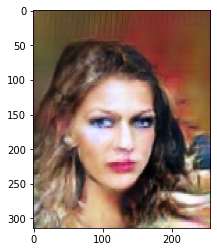

In [386]:
# load the desired Generator checkpoint
# select dedsired epoch
epoch = 5
model_path = f'./final_binaries/G-DCGAN-{epoch}.pt' 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# instantiate model
generator = ConvolutionalGenerativeNet().to(device)
# load model weights from checkpoint
generator.load_state_dict(torch.load(model_path)['model_state_dict'])
# set to validation phase: don't update gradients, no batchnorm in validation phase
generator.eval() 

# store generated images here 
generated_image_path = './images'

# Generate faces (using DCGAN Generator trained on CelebA)
print('Generating celebrity face')
generated_image = generate_from_random_latent_vector(generator)
save_image(generated_image_path, generated_image, display=True)

### 10 Epochs

Generating celebrity face


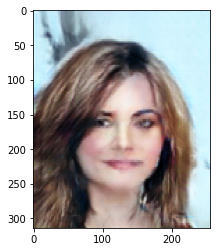

In [387]:
# load the desired Generator checkpoint
# select dedsired epoch
epoch = 10
model_path = f'./final_binaries/G-DCGAN-{epoch}.pt' 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# instantiate model
generator = ConvolutionalGenerativeNet().to(device)
# load model weights from checkpoint
generator.load_state_dict(torch.load(model_path)['model_state_dict'])
# set to validation phase: don't update gradients, no batchnorm in validation phase
generator.eval() 

# store generated images here 
generated_image_path = './images'

# Generate faces (using DCGAN Generator trained on CelebA)
print('Generating celebrity face')
generated_image = generate_from_random_latent_vector(generator)
save_image(generated_image_path, generated_image, display=True)

### 25 Epochs

Generating celebrity face


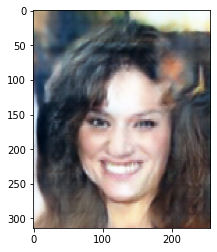

In [413]:
# load the desired Generator checkpoint
# select dedsired epoch
epoch = 25
model_path = f'./final_binaries/G-DCGAN-{epoch}.pt' 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# instantiate model
generator = ConvolutionalGenerativeNet().to(device)
# load model weights from checkpoint
generator.load_state_dict(torch.load(model_path)['model_state_dict'])
# set to validation phase: don't update gradients, no batchnorm in validation phase
generator.eval() 

# store generated images here 
generated_image_path = './images'

# Generate faces (using DCGAN Generator trained on CelebA)
print('Generating celebrity face')
generated_image = generate_from_random_latent_vector(generator)
save_image(generated_image_path, generated_image, display=True)

### 37 Epochs

Generating celebrity face


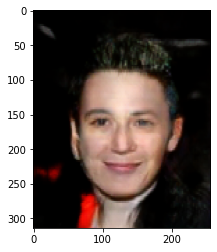

In [443]:
# load the desired Generator checkpoint
# select dedsired epoch
epoch = 37
model_path = f'./binaries/G-DCGAN-{epoch}.pt' 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# instantiate model
generator = ConvolutionalGenerativeNet().to(device)
# load model weights from checkpoint
generator.load_state_dict(torch.load(model_path)['model_state_dict'])
# set to validation phase: don't update gradients, no batchnorm in validation phase
generator.eval() 

# store generated images here 
generated_image_path = './images'

# Generate faces (using DCGAN Generator trained on CelebA)
print('Generating celebrity face')
generated_image = generate_from_random_latent_vector(generator)
save_image(generated_image_path, generated_image, display=True)

Now that might fool me even on a good day - it's certainly a palatable human face, perhaps even a little celebrity-like.  

# Lessons Learned: How to Stabilize and Optimize a GAN

The difficulty of training the GAN speaks for itself - once you give it a shot. Achieving stability in training and ensuring convergence (of the min-max game between the Generator and Discriminator) to a nash equillibrium is not nearly as easy as it is made out to be by recent papers implementing weight and image regularization techniques such as SELU and Spectral Norm. I've concluded that the plain DCGAN, even with contemporary regularization, doesn't quite cut it. [Progressively Growing GANs](https://arxiv.org/abs/1710.10196) and the [MSG-GAN](https://arxiv.org/abs/1903.06048) are some better candidates for truly impressive results at higher resolutions. 

**Here's what I've gathered from trying to get something impressive out of the plain DCGAN architecture:**

**Training and Failure Modes:**
- Best results are rarely at the last epoch of training - check intermediate epochs, because the generator's output sometimes degrades before picking back up
- When the DCGAN is properly tuned, D loss decreases with time and has low variance.
- When G loss is low or consistently decreases, it's likely fooling D with garbage images.
- Slowing down D with different learning rates as in the TTUR paper sometimes works, but isn't necessary with proper normalization (SpectralNorm + Noise).
- We can actually get away with a 5-10x faster learning rate on D when using all the regularization techniques in this notebook: Spectral Norm + Gaussian Instance Noise + Dropout.
- Slowing down D with altered learning schedule (training D/G in a for loop for each batch) won't avoid training collapse - it'll only delay it.

**Architecture/Hyperparameters:**
- More filters is not better. 512 is a good maximum. 64 filters in each layer of both G and D works decently as well. Other hyperparams appear more important.
- Use Dropout ONLY ON D, and not on its final layer. Using dropout on G leads to poor generated images.
- Use Gaussian Instance Noise ONLY ON D - works well on input or in multiple layers (but not the last layer). Use in G causes it to be unable to generate decent images early on and it never recovers. 
- Adding Gaussian Instance Noise generally made discriminator less sensitive to hyperparameters.
- Gaussian Noise didn't seem to make a big difference to stability of D when using SpectralNorm + BatchNorm.
- SpectralNorm is a powerful normalization technique and can be used together with BatchNorm in G.
- SpectralNorm performed better alone than SpectralNorm + BatchNorm in D. Both improved performance in G.
- SpectralNorm can replace the normalization power of SELU, working well with leakyReLU.
- Large batch is much faster to train (1024), but smaller batches train MUCH better GANs.
- Batch in radford et al (128) works well; smaller batches (64, 32) are more stable but slower to train.

**Activation & Optimizers:**
- Activation function: In terms of performance for this model, I found LeakyReLU+ReLU to lead to faster equillibrium than SELU, though SELU also produced good generated images.
- Use BCELossWithLogits and no sigmoid activation on final discriminator layer: More stable than BCELoss() because of log-sum-exp trick.
- Optimizer: I found AdamW to work better than Adam. AdamW is better than SGD for discriminator, although SGD has been used to slow down the discriminator - it seems SGD slows down D too much with proper discriminator normalization.
- SELU from HDCGAN paper (SNN): Performed as well as LeakyReLU for this model. SpecNorm+BatchNorm probably means weights are already regularized such that SELU behaves similarly to LeakyReLU. 
- SELU is indeed self normalizing, as it produced decent images even without SpectralNorm and BatchNorm - however, I found it better to have explicit normalization such as SpecNorm and BatchNorm and just use LeakyReLU + ReLU. 

**Other tricks:**
- One-sided label smoothing: set discriminator labels for real images from 1 -> 0.9 to make the only the discriminator's job harder.
- Popular GANHacks GitHub page incorrectly says to smooth both real and fake labels (1->0.9, 0->0.1).
- Pixelwise Normalization didn't really change performance, just added complexity. Likely due to Spectral Normalization.
- Minibatch Standard Deviation didn't help much either. Again, likely has to do with Spectral Normalization working so well. 


<br>

**Thanks for reading - I sincerely appreciate it. Any comments, errors, or questions, please drop me a line at ilzenkov@gmail.com.** 




# References
- Arjovsky and Bottou, 2017. Towards Principled Methods for Training Generative Adversarial Networks. https://arxiv.org/abs/1701.04862
- Arjovsky et al, 2017. Wasserstein GAN. https://arxiv.org/abs/1701.07875 
- Curto et al, 2020. High-resolution Deep Convolutional Generative Adversarial Networks. https://arxiv.org/pdf/1711.06491.pdf
- Dumoulin and Visin, 2018. A guide to convolution arithmetic for deep learning. https://arxiv.org/pdf/1603.07285.pdf
- Goodfellow et al, 2014. Generative Adversarial Networks. https://arxiv.org/abs/1406.2661
- Heusel et al, 2017. GANs Trained by a Two Time-Scale Update Rule Converge to a Local Nash Equilibrium. https://arxiv.org/abs/1706.08500
- Jenni and Favaro, 2019. On Stabilizing Generative Adversarial Training with Noise. https://arxiv.org/abs/1906.04612
- Karras et al, 2017. Progressive Growing of GANs for Improved Quality, Stability, and Variation. https://arxiv.org/abs/1710.10196
- Klambauer et al, 2017. Self-Normalizing Neural Networks. https://arxiv.org/abs/1706.02515
- Liu et al, 2016. Large-scale CelebFaces Attributes (CelebA) Dataset. http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html
- Mescheder et al, 2018. Which Training Methods for GANs do actually Converge? https://arxiv.org/pdf/1801.04406.pdf
- Miyato et al, 2018. Spectral Normalization for Generative Adversarial Networks. https://arxiv.org/abs/1802.05957
- Radford et al, 2015. Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks. https://arxiv.org/abs/1511.06434
- Salimans et al, 2016. Improved Techniques for Training GANs. https://arxiv.org/pdf/1606.03498.pdf
- Sonderby et al, 2016. Amortised MAP Inference for Image Super-resolution. https://arxiv.org/abs/1610.04490


Notable mention to GanHacks GitHub: https://github.com/soumith/ganhacks/blob/master/README.md


# Appendix A

## Animating GAN Training Progress

We can use imageio to take all the intermediate debug images dumped during training and write it to a GIF. We'll need to load, resize, and rescale the images out of OpenCV format.

We'll wrap imageio.mimwrite to write a series of images from our debug image path at a chosen framerate, and implement downsampling so we don't end up with a 2GB GIF. 




In [126]:
import imageio

# load a single face image from disk, resize if desired
def load_image(img_path, target_shape=None):

    # convert openCV BGR images back into RGB
     # [:, :, ::-1] converts BGR (images saved in opencv format) into RGB
    img = cv.imread(img_path)[:, :, ::-1] 

    # resize with OpenCV
    if target_shape is not None:  # resize section
        if isinstance(target_shape, int) and target_shape != -1:  
            current_height, current_width = img.shape[:2]
            new_width = target_shape
            new_height = int(current_height * (new_width / current_width))
            img = cv.resize(img, (new_width, new_height), interpolation=cv.INTER_CUBIC)
        else:  # set both dimensions to target shape
            img = cv.resize(img, (target_shape[1], target_shape[0]), interpolation=cv.INTER_CUBIC)

    # normalize to [0,1] range after cv.resize pushes it out of that range
    img = img.astype(np.float32)  # convert from uint8 to float32
    img /= 255.0  # get to [0, 1] range
    return img

def create_gif(frames_dir, out_path, downsample=1, img_width=None, fps=60, start_frame = 0, stop_frame=None):
    # get images saved as .jpg
    frame_paths = [os.path.join(frames_dir, frame_name) for count, frame_name in enumerate(os.listdir(frames_dir)) if count % downsample == 0]
    
    # for resizing image for GIF
    if img_width is not None: 
        for frame_path in frame_paths:
            img = load_image(frame_path, target_shape=img_width)
            cv.imwrite(frame_path, np.uint8(img[:, :, ::-1] * 255))

    # make sure we build the GIF from first to last image to visualize G's learning
    frame_paths.sort()
    
    # store list of images from frame_path 
    images = [imageio.imread(frame_path) for frame_path in frame_paths]

    # truncate images at stop frame if provided 
    if stop_frame:
        images = images[start_frame:stop_frame]

    # make it into a gif with mimwrite, which writes a series of images to the specified URI (out_path)
    imageio.mimwrite(out_path, images, fps=fps)

    print(f'\nGIF saved to {out_path} at {fps} FPS.')

In [496]:
# debug_path/xxxxxx.jpg contains all intermediate generated training images 
create_gif('debug_path_final', 'debug_path_final.gif', downsample=100, fps = 5, stop_frame=400)
#create_gif('debug_path_relu_nospecD', 'debug_path_relu_nospecD.gif', downsample=2, fps = 20)
#create_gif('debug_pathSELU', 'debug_pathSELU.gif', downsample=2, fps = 20)

GIF saved to debug_path_final.gif at 5 FPS.


In [486]:
!unzip -q debug_path_final.zip

And here's a sample of what we get:

<img src="generated_images/training_progress 2.gif">

And here's when things go wrong - this is an example of mode collapse:

<img src="generated_images/mode_collapse.gif">


## Spherical Interpolation

We can save the various latent vectors (_z_) we use to generate images, and then use these vectors to interpolate between them, generating new images. This can help us deduce which features are present in a certain latent vector - but it's mostly for fun.

Spherical interpolation is suggested over linear interpolation for GANs by [GAN Hacks](https://github.com/soumith/ganhacks). 

In [117]:
# Suggested to use slerp instead of linear interp for GANs by https://github.com/soumith/ganhacks
# Spherical interpolation formula from https://en.wikipedia.org/wiki/Slerp
def spherical_interpolation(t, p0, p1):
    # t is the interpolation parameter in range [0,1]
    # p0 and p1 are the two latent vectors 
    if t <= 0:
        return p0
    elif t >= 1:
        return p1
    elif np.allclose(p0, p1):
        return p0

    # Convert p0 and p1 to unit vectors and find the angle between them (omega)
    omega = np.arccos(np.dot(p0 / np.linalg.norm(p0), p1 / np.linalg.norm(p1)))
    return np.sin((1.0 - t) * omega) /  np.sin(omega) * p0 + np.sin(t * omega) /  np.sin(omega) * p1

# generates intermediate interpolated imagery 
# between two latent vectors a and b using 
def interpolation_gif(generator, a, b, gif_dir='interpolation_result', image_dir='images', fps=5):
    
    # number of images between the vectors a and b, including a and b
    interpolation_resolution = 48 

    # make intermediate image directory and gif directory
    os.mkdir(image_dir)

    # store intermediate images 
    generated_imgs = []

    for i in range(interpolation_resolution):
        # t in range [0,1] i.e. fraction of total interpolation
        t = i / (interpolation_resolution - 1) 
        # generate intermediate interpolated vector
        current_latent_vector = spherical_interpolation(t, a, b)
        # convert to tensor for compatibility with image processing functions previously defined
        current_latent_vector = torch.unsqueeze(torch.tensor(current_latent_vector, device='cuda'), dim=0)
        # generate image from latent vector and process for saving
        generated_img = process_generated_image(generator(current_latent_vector))#.detach())
        # track progress for sanity
        print('\r'+f'Image {i+1}/{interpolation_resolution} processed',end='')
        # make directory to save intermediate images
        
        # save intermediate interpolated image 
        save_image(image_dir, generated_img)
        # convert from openCV (H,W,C) to (C,H,W) for torchvision.utils.save_image
        # make list of interpolated images 
        generated_imgs.append(torch.tensor(np.moveaxis(generated_img, 2, 0)))
    
    # make a GIF of the interpolation
    create_gif(image_dir, gif_dir+'.gif', downsample=1, fps = fps)

In [123]:
# load the desired Generator checkpoint
# select dedsired epoch
epoch = 37
model_path = f'./final_binaries/G-DCGAN-{epoch}.pt' 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# instantiate model
generator = ConvolutionalGenerativeNet().to(device)
# load model weights from checkpoint
generator.load_state_dict(torch.load(model_path)['model_state_dict'])
# set to validation phase: don't compute gradients/update weights, no batchnorm in validation phase
generator.eval() 

# generate two random Gaussian latent vectors 
z1 = np.random.normal(size=100).astype('Float32')
z2 = np.random.normal(size=100).astype('Float32')

# generate and save interpolated images between z1 and z2
# make a couple of gifs so we can pick through them later 
for i in range(5):

    # generate two random Gaussian latent vectors 
    z1 = np.random.normal(size=100).astype('Float32')
    z2 = np.random.normal(size=100).astype('Float32')

    # create interpolations between z1 and z2, and save to a gif
    interpolation_gif(generator, z1, z2, fps=10, image_dir=f'____interpolation-{i}', gif_dir=f'____interpolated_gifs/interp-{i}')



Image 48/48 processed
GIF saved to ____interpolated_gifs/interp-0.gif at 10 FPS.
Image 48/48 processed
GIF saved to ____interpolated_gifs/interp-1.gif at 10 FPS.
Image 48/48 processed
GIF saved to ____interpolated_gifs/interp-2.gif at 10 FPS.


<img src="generated_images/interpolation/interp-2.gif">

## CelebA Attributes
We can make a dictionary to hold the attributes so we can play with the trained DCGAN later on. Attributes from Liu et al's baidu drive 'list_attr_celeba.txt'.

**This will mostly be useful to figure out which feature is which using linear interpolation once our generator is trained; for labelling samples we would use an Auxilliary GAN (AC-GAN) where we embed image labels into an extra tensor dimension.**

In [ ]:
# CelebA dataset attributes 
attributes_dict = {
    '5_o_Clock_Shadow': torch.bool,
    'Arched_Eyebrows': torch.bool,
    'Attractive': torch.bool,
    'Bags_Under_Eyes': torch.bool,
    'Bald': torch.bool,
    'Bangs': torch.bool,
    'Big_Lips': torch.bool,
    'Big_Nose': torch.bool,
    'Black_Hair': torch.bool,
    'Blond_Hair': torch.bool,
    'Blurry': torch.bool,
    'Brown_Hair': torch.bool,
    'Bushy_Eyebrows': torch.bool,
    'Chubby': torch.bool,
    'Double_Chin': torch.bool,
    'Eyeglasses': torch.bool,
    'Goatee': torch.bool,
    'Gray_Hair': torch.bool,
    'Heavy_Makeup': torch.bool,
    'High_Cheekbones': torch.bool,
    'Male': torch.bool,
    'Mouth_Slightly_Open': torch.bool,
    'Mustache': torch.bool,
    'Narrow_Eyes': torch.bool,
    'No_Beard': torch.bool,
    'Oval_Face': torch.bool,
    'Pale_Skin': torch.bool,
    'Pointy_Nose': torch.bool,
    'Receding_Hairline': torch.bool,
    'Rosy_Cheeks': torch.bool,
    'Sideburns': torch.bool,
    'Smiling': torch.bool,
    'Straight_Hair': torch.bool,
    'Wavy_Hair': torch.bool,
    'Wearing_Earrings': torch.bool,
    'Wearing_Hat': torch.bool,
    'Wearing_Lipstick': torch.bool,
    'Wearing_Necklace': torch.bool,
    'Wearing_Necktie': torch.bool,
    'Young': torch.bool,
    }

## Wasserstein Loss: The WGAN
In addition to the many normalization techniques above, one way to avoid mode collapse is by using [Wasserstein loss, as first described by Arjovsky et al, 2017](https://arxiv.org/abs/1701.07875) instead of adversarial loss as described by Radford et al. Wasserstein loss measures the distance between two probability distributions (similar to KL divergence, used in sparse autoencoders to ensure training weights are close to 0 in each hidden layer of a network). Roughly speaking, Wasserstein loss computes the quantity (percentage) of the difference between probability distributions, and the distance between the portion of the probability disributions which are different. [Earth mover's distance](https://en.wikipedia.org/wiki/Earth_mover%27s_distance) is another name for Wasserstein loss, and here's why: We imagine two different probability disributions as two differently-shaped dirt piles: the Wasserstein distance (loss) is then the product of the amount of dirt moved and the distance over which it is moved so that the two piles take on the exacft same shape. Wasserstein distance quantifies the minimum energy cost in transforming one probability distribution into the shape of another. **Wasserstein loss ultimately penalizes the generator w.r.t. the distance between the probability distributions of generated training images _P<sub>z</sub>_ and real training images _P<sub>data</sub>_**